Assignemnt

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os




---


# Loading dataset
---



In [11]:
zip_path = "/content/sample_data/data.zip"
extract_path = "/content/cats_dogs_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")


Dataset unzipped successfully.


In [12]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32




---
Normalising and resezing


---



In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    extract_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    extract_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Class indices: {'cats_set': 0, 'dogs_set': 1}


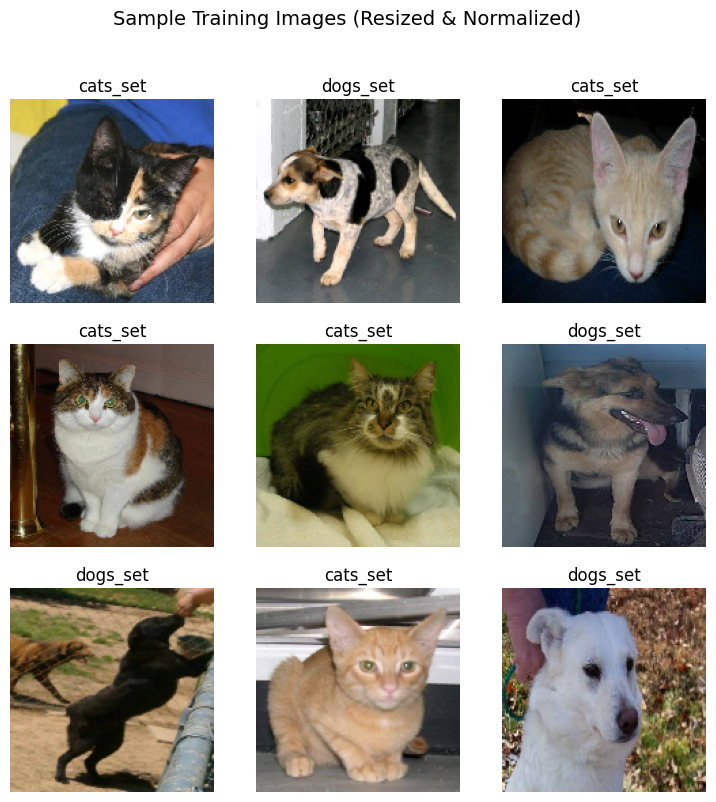

In [14]:
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

plt.suptitle("Sample Training Images (Resized & Normalized)", fontsize=14)
plt.show()


In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])




---

# Training

---



In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


/tmp/ipython-input-1915760215.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.7322 - loss: 0.6134 - val_accuracy: 0.9400 - val_loss: 0.1671
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9056 - loss: 0.1972 - val_accuracy: 0.9400 - val_loss: 0.1611
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9460 - loss: 0.1453 - val_accuracy: 0.9250 - val_loss: 0.2022
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9427 - loss: 0.1332 - val_accuracy: 0.9450 - val_loss: 0.1621
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9476 - loss: 0.1222 - val_accuracy: 0.9250 - val_loss: 0.2061
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9743 - loss: 0.0852 - val_accuracy: 0.9250 - val_loss: 0.2292
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9624 - loss: 0.1124 - val_accuracy: 0.9200 - val_loss: 0.2325
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9513 - loss: 0.1032 - val_accuracy: 0.9050 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


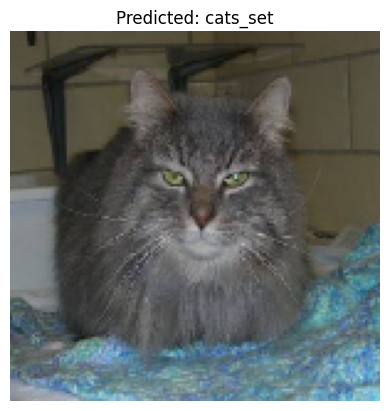

In [ ]:
# Get one image from validation set
sample_image, sample_label = next(val_generator)

prediction = model.predict(sample_image)
predicted_class = (prediction[0] > 0.5).astype(int)[0]

plt.imshow(sample_image[0])
plt.title(f"Predicted: {class_names[predicted_class]}")
plt.axis("off")
plt.show()


In [ ]:
model.save("cats_dogs_mobilenetv2.h5")
print("Model saved successfully.")


Model saved successfully.


In [ ]:
model.save("cats_dogs_mobilenetv2.keras")




---



---

